In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse
from ast import literal_eval
from sklearn.preprocessing import normalize
# import cugraph ## this library works with CUDA-capable GPUs but has many issues

In [2]:
PATH_TO_DATA = Path('../data')

## Creating DataFrames for body and title

'PROPERTIES' columns contain the so-called **Word2Vec Model Matrix**, these are going to be converte to numerical using the (fastest possible) mapping via _literal\_eval_ function.
The first 22 values in 'PROPERTIES' fields are to be discarded since they do not represent semantic information about the post (see [here](https://snap.stanford.edu/data/soc-RedditHyperlinks.html)).

These steps should take ~35s+70s

In [5]:
body_df = pd.read_csv(PATH_TO_DATA/'soc-redditHyperlinks-body.tsv', sep='\t', converters={'PROPERTIES': literal_eval})
body_df['TIMESTAMP'] = pd.to_datetime(body_df.TIMESTAMP)
body_df['PROPERTIES'] = body_df['PROPERTIES'].map(lambda x : np.array(x)[22:])
body_df = body_df.sort_values(by='TIMESTAMP').reset_index()
body_df = body_df[-3000:].reset_index()
body_df

,level_0,index,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,283561,283493,bluejackets,hockey,66m85ss,2017-04-20 18:37:34,1,"[0.004830917874396135, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,283562,283873,szechuansauceseekers,rickandmorty,66tywis,2017-04-20 19:11:57,1,"[0.07804232804232804, 0.03835978835978836, 0.0..."
2,283563,283499,muacirclejerk,makeupaddiction,66meods,2017-04-20 19:13:40,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,283564,283498,cryptocurrency,nem,66mcdvs,2017-04-20 19:15:59,1,"[0.09176470588235294, 0.08470588235294117, 0.0..."
4,283565,283502,twobestfriendsplay,forhonor,66mfujs,2017-04-20 19:17:52,1,"[0.07407407407407407, 0.037037037037037035, 0...."
...,...,...,...,...,...,...,...,...
2995,286556,286559,electricskateboards,askreddit,68ipb2s,2017-04-30 16:41:53,1,"[0.13513513513513514, 0.09009009009009009, 0.0..."
2996,286557,286539,dndbehindthescreen,dndhomebrew,68i9cxs,2017-04-30 16:43:37,1,"[0.020737327188940093, 0.0034562211981566822, ..."
2997,286558,286560,mgtow,dataisbeautiful,68ipeos,2017-04-30 16:52:59,1,"[0.0718232044198895, 0.022099447513812154, 0.0..."
2998,286559,286558,mmorpg,blackdesertonline,68ip5os,2017-04-30 16:54:08,1,"[0.1625615763546798, 0.06403940886699508, 0.02..."


In [6]:
title_df = pd.read_csv(PATH_TO_DATA/'soc-redditHyperlinks-title.tsv', sep='\t', converters={'PROPERTIES': literal_eval})
title_df['TIMESTAMP'] = pd.to_datetime(title_df.TIMESTAMP)
title_df['PROPERTIES'] = title_df['PROPERTIES'].map(lambda x : np.array(x)[22:])
title_df = title_df.sort_values(by='TIMESTAMP').reset_index()
title_df = title_df[-3000:].reset_index()
title_df

,level_0,index,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,568927,568873,procss,area11band,67q9kes,2017-04-26 11:54:58,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,568928,570506,1d6adventurers,monsteraday,6855hrs,2017-04-26 11:54:59,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,568929,568079,1d6adventurers,monsteraday,67ira2s,2017-04-26 11:54:59,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,568930,567341,1d6adventurers,monsteraday,67b5gvs,2017-04-26 11:54:59,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,568931,569671,1d6adventurers,monsteraday,67xzrts,2017-04-26 11:54:59,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2995,571922,571894,peoplewhosayheck,re_zero,68igifs,2017-04-30 16:36:07,1,"[0.15789473684210525, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2996,571923,571908,peoplewhosayheck,divorce,68ijym,2017-04-30 16:36:07,-1,"[0.07142857142857142, 0.07142857142857142, 0.0..."
2997,571924,571902,peoplewhosayheck,teenmom,68ii97s,2017-04-30 16:36:07,1,"[0.12, 0.08, 0.0, 0.0, 0.0, 0.08, 0.0, 0.04, 0..."
2998,571925,571921,brasilonreddit,roadcam,68ipe8s,2017-04-30 16:47:50,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Create Similarity Matrix

In order to create the **Similarity Matrix**, we should _extract_ the 'PROPERTIES' vectors and then we should _calculate the distances_ of all the posts (exploiting the simple dot product).

This step should take

In [7]:
# articles = title_df.copy()
articles = body_df.copy()
# articles = title_df[[x.year > 2016 for x in title_df['TIMESTAMP']]].reset_index().copy()
# articles = body_df[[x.year > 2016 for x in body_df['TIMESTAMP']]].reset_index().copy()
docvs = np.array(list(articles['PROPERTIES'])).copy()
#del title_df, body_df

Technically, these arrays have to be normalized.
The fastest method found is this from sklearn.
The main issue is that when computing the distance matrix, even when using sparse matrices, the computation is going to take up to ~30GB RAM.
I'm trying to found alternative solutions, until then **DO NOT NORMALIZE THIS MATRIX!!**

In [8]:
# Alternative normalization procedure
row_sums = docvs.sum(axis=1)
np_docvs_norm = docvs / row_sums[:, np.newaxis]
print("Shape of normalized matrix is {}.".format(np_docvs_norm.shape))
print("Sum of normalized matrix is {}.".format(np.sum(np_docvs_norm)))
print("Max={}; Min={}.".format(np.max(np_docvs_norm), np.min(np_docvs_norm)))

sk_docvs_norm = normalize(docvs)
print("Shape of normalized matrix is {}.".format(sk_docvs_norm.shape))
print("Sum of normalized matrix is {}.".format(np.sum(sk_docvs_norm)))
print("Max={}; Min={}.".format(np.max(sk_docvs_norm), np.min(sk_docvs_norm)))

Shape of normalized matrix is (3000, 64).
Sum of normalized matrix is 3000.0.
Max=0.7053571428571428; Min=0.0.
Shape of normalized matrix is (3000, 64).
Sum of normalized matrix is 13034.083116758247.
Max=0.9948328284118325; Min=0.0.


Computation of the distance matrix.
The simple dot product is used between the matrix and its transpose.

In [10]:
s = sparse.csr_matrix(sk_docvs_norm)
s_t = sparse.csr_matrix(sk_docvs_norm).T
s_dist = s.dot(s_t)
dists_triu = sparse.triu(s_dist, k=1)
dists_triu = dists_triu.todense()
np.savetxt('../data/dists_triu.csv', dists_triu, delimiter=',')

In [ ]:
dists = np.dot(sk_docvs_norm, sk_docvs_norm.T)
# dists = np.dot(docvs, docvs.T)
dists_triu = np.triu(dists, k=1)
del docvs, dists
dists_triu
np.savetxt('../data/dists_triu.csv', dists_triu, delimiter=',')

These methods, used for building the graph, have been extracted and adapted from [this repo](https://github.com/elisamussumeci/modeling-news-spread).

In [11]:
def get_pos(data, pub_i, column_list, time_max, sim_min, outs):
    ans = False
    pos = None

    while ans is False:
        sim = max(column_list)
        pos = column_list.index(sim)
        time_dif = (pub_i - data['TIMESTAMP'][pos]).total_seconds() / 3600
        if sim < sim_min:
            pos = None
            ans = True
        elif pos in outs or time_dif > time_max:
            column_list[pos] = 0
        else:
            ans = True
    return pos

def create_graph(dists_triu, data, time_max=168, sim_min=0.8):
    size = dists_triu.shape[0]
    G = nx.DiGraph()
    G.add_node(0, step=0, date=data['TIMESTAMP'][0], domain=data['SOURCE_SUBREDDIT'][0], _id=data['POST_ID'][0],
              children=[])
    outs = []
    for i in range(1,size):
        pub_i = data['TIMESTAMP'][i]
        column = list(dists_triu[:, i])
        pos = get_pos(data, pub_i, column, time_max, sim_min, outs)

        if pos != None:
            if pos not in G.nodes():
                domain_1 = data['SOURCE_SUBREDDIT'][pos]
                G.add_node(pos, date=data['TIMESTAMP'][pos], domain=domain_1,
                           _id=data['POST_ID'][pos], children=[])
            if i not in G.nodes():
                domain_2 = data['SOURCE_SUBREDDIT'][i]
                G.add_node(i, date=pub_i, domain=domain_2, _id=data['POST_ID'][i], children=[])

            G.add_edge(pos, i)
        else:
            outs.append(i)
    return G

def create_date(pub1, pub2, s):
    dif = (pub2-pub1).total_seconds()/3600
    return round((dif/s))

def create_graphml(dists_triu, data, time_max=168, sim_min=0.8):
    size = dists_triu.shape[0]
    G = nx.DiGraph()
    G.add_node(0, step=0, date=0, domain=data['SOURCE_SUBREDDIT'][0])
    date_init = data['TIMESTAMP'][0]
    outs = []
    for i in range(1, size):
        pub_i = data['TIMESTAMP'][i]
        column = list(dists_triu[:,i])
        pos = get_pos(data, pub_i, column, time_max, sim_min, outs)

        if pos != None:
            if pos not in G.nodes():
                domain_1 = data['SOURCE_SUBREDDIT'][pos]
                date_1 = create_date(date_init, data['TIMESTAMP'], 5)
                G.add_node(pos, date=date_1, domain=domain_1)
            if i not in G.nodes():
                domain_2 = data['SOURCE_SUBREDDIT'][i]
                date_2 = create_date(date_init, pub_i, 5)
                G.add_node(i, date=date_2, domain=domain_2)

            G.add_edge(pos, i)
        else:
            outs.append(i)
    return G

def create_matrix_domain(graph):
    
    domain_list = []
    for pos in graph.nodes():
        node = graph.nodes()[pos]
        d = node['domain']
        if d not in domain_list:
            domain_list.append(d)

    df = pd.DataFrame(0, index = domain_list, columns = domain_list)

    for pos in graph.nodes():
        node = graph.nodes()[pos]
        d = node['domain']
        successors = graph.successors(pos)
        for suc in successors:
            df[d][graph.nodes()[suc]['domain']] += 1

    return [domain_list, df]

def create_complete_adjacency(graph, matrix):
    df = pd.DataFrame(0, index=graph.nodes(), columns=graph.nodes())
    for column in graph.nodes():
        i_domains_column = matrix[graph.nodes()[column]['domain']]
        for row in graph.nodes():
            prob = i_domains_column[graph.nodes()[row]['domain']]
            df[column][row] = prob

    return df

Creating, saving and drawing the Graphs instatiated using _networkX_ library.
This step should take ~6min.

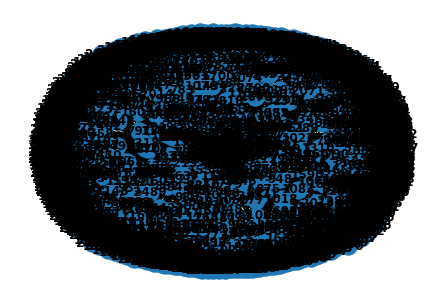

AttributeError: 'DiGraph' object has no attribute 'node'

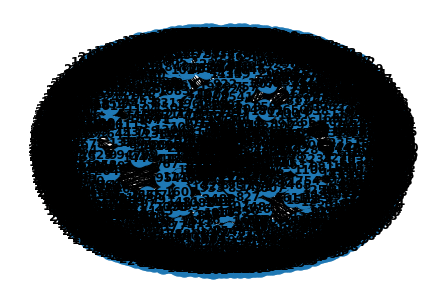

In [13]:
G = create_graph(dists_triu, articles)
nx.write_gpickle(G, '../data/empirical_graph.gpickle')
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()
H = create_graphml(dists_triu, articles)
nx.write_graphml(H, '../data/empirical_graph.graphml')
# nx.draw(H, with_labels=True, font_weight='bold')

pd.DataFrame(dict(G.nodes())).transpose().to_csv('../data/empirical_graph_nodes.csv')
all_nodes_domains = []
for i in empirical_nodes:
    all_nodes_domains.append(G.nodes()[i]['domain'])

f = open('../data/graph_original_domains_each_node.txt', 'w')
for item in all_nodes_domains:
    f.write("%s\n" % item)

domain_list, domain_matrix = create_matrix_domain(G)

graph_complete = create_complete_adjacency(G, domain_matrix)
as_numpy = graph_complete.as_matrix()
np.fill_diagonal(as_numpy, 0)
np.savetxt('../data/graph_complete.csv', as_numpy, delimiter=',')
graph_complete

In [ ]:
domain_list, domain_matrix = create_matrix_domain(G)

graph_complete = create_complete_adjacency(G, domain_matrix)
as_numpy = np.array(graph_complete)
np.fill_diagonal(as_numpy, 0)
np.savetxt('../data/graph_complete.csv', as_numpy, delimiter=',')
as_numpy

Methods for initializing the dynamic simulation and creating the initial state.

In [37]:
def create_first_pubs(original_graph):
    dates_list = [original_graph.nodes()[node]['date'] for node in original_graph.nodes()]
    fs = []
    for node in original_graph.nodes():
        if original_graph.nodes()[node]['date'].date() == min(dates_list).date():
            fs.append(original_graph.nodes()[node]['domain'])
    return fs


def create_i0(list_first_pubs, domains):
    i0 = np.zeros(len(domains))
    for pos, i in enumerate(i0):
        if domains[pos] in list_first_pubs:
            i0[pos] = 1
            list_first_pubs.remove(domains[pos])

    return i0

Initialization

In [39]:
list_first_pubs = create_first_pubs(G)
I0 = create_i0(list_first_pubs, all_nodes_domains)
np.savetxt('../data/i0.csv', I0, delimiter=',')
I0